In [3]:
import pandas as pd
import numpy as np
import json
import os
import joblib

import matplotlib.pyplot as plt

from preprocessing_utils import ScaleData, SplitData
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

# import nn from torch
import torch
import torch.nn as nn

In [4]:
stock_tickers = pd.read_csv('data/SP500_tickers_clean.csv', index_col=0)
stock_data = pd.read_csv('data/SP500_stock_prices_log_clean_3monthreturn.csv', index_col=0, parse_dates=True)

In [5]:
minmax_scaled_data, minmax_f_scaler, minmax_t_scaler = ScaleData(stock_data, split_date='2018-10-01', scaler=MinMaxScaler())
robust_scaled_data, robust_f_scaler, robust_t_scaler = ScaleData(stock_data, split_date='2018-10-01', scaler=RobustScaler())

In [16]:
def GetResultsFromJSON(ticker, fold, exp_dir):
    result_dir = f"{exp_dir}/fold{fold}/{ticker}/model_losses.json"
    with open(result_dir, 'r') as f:
        results = json.load(f)
    return results

def UnscaleResults(results, scaler):
    results_unscaled = {}
    for key, value in results.items():
        results_unscaled[key] = scaler.inverse_transform(np.array(value).reshape(-1, 1)).tolist()
    return results_unscaled

def SplitDF(df, split_date):
    ticker_rows_train = df.loc[df.index < split_date].copy()
    ticker_rows_test = df.loc[df.index >= split_date].copy()
    return ticker_rows_train, ticker_rows_test.iloc[:63]

def Unscale(databatches, target_scaler): 
    unscaled_batches = []
    for data in databatches:
        data_numpy = data.detach().cpu().numpy().reshape(-1, 1)
        unscaled_data_numpy = target_scaler.inverse_transform(data_numpy)
        unscaled_batches.append(torch.from_numpy(unscaled_data_numpy).to(data.device))
    
    return unscaled_batches

In [20]:
torch.tensor([1, 2, 3]).reshape(-1, 1)

tensor([[1],
        [2],
        [3]])

In [14]:
trial_data = stock_data[stock_data['Ticker'] == 'AAPL'].iloc[:10,:]
num_cols = trial_data.drop(columns=['Ticker', 'Sector']).columns

In [8]:
scaled_trial = minmax_f_scaler.transform(trial_data[num_cols])
unscaled_trial = minmax_f_scaler.inverse_transform(scaled_trial)
(trial_data[num_cols].values - unscaled_trial)[:10]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.22124533e-14],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.86517468e-14],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -2.42028619e-14],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  2.08721929e-14],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -4.75175455e-14],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -3.06421555e-14],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  3.81916720e-14],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  2.66453526e-14],
       [ 0.00000000e+00,  0.00000000e+00,  0.000

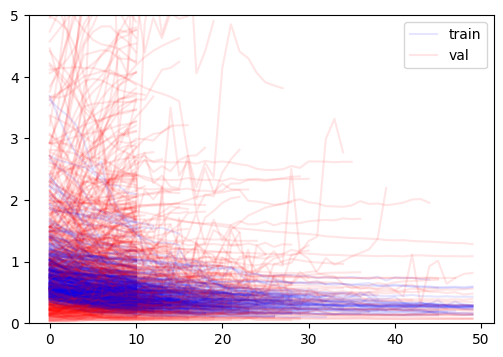

In [9]:
### different learning rates and schedulers here, e.g. factor to 0.5 instead of 0.1
# lr rate scheduler cyclic and cosine annealing warm restarts
# no MCD in these, maybe there is one other model that used it? We can check if 
# each prediction has a variance that makes sense, and not just 0

plt.figure(figsize=(6, 4), dpi=100)

for ticker in stock_tickers['Ticker']:
    results = GetResultsFromJSON(ticker=ticker, fold=2, exp_dir="experiments/exp_robust")
    plt.plot(results['train_losses'], color="blue", alpha=0.1)
    plt.plot(results['val_losses'], color="red", alpha=0.1)

# manual coloring, blue for val, red for train in legend
plt.ylim(0, 5)
plt.legend(["train", "val"])


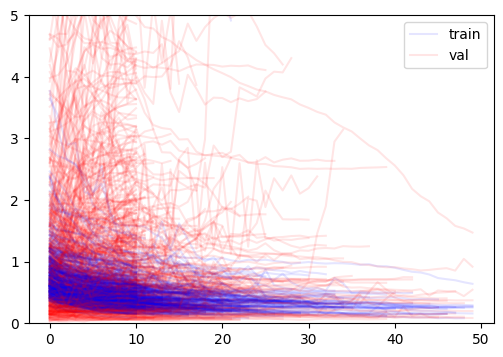

In [10]:
# we check the robust scaler again, but with a factor of 0.5 instead of 0.1

plt.figure(figsize=(6, 4), dpi=100)

for ticker in stock_tickers['Ticker']:
    results = GetResultsFromJSON(ticker=ticker, fold=2, exp_dir="experiments/exp_rob-f0.5")
    plt.plot(results['train_losses'], color="blue", alpha=0.1)
    plt.plot(results['val_losses'], color="red", alpha=0.1)

# manual coloring, blue for val, red for train in legend
plt.ylim(0, 5)
plt.legend(["train", "val"])


In [11]:
"""
Conclusion might be we could allow them to train for longer? Quite a few reach 50 epochs, so we should see what they can do at 100
There are still however alot that just die out asap, Dont know how we can prevent that.

We have to check the learning rate schedulers, to see how they impact the result. Myabe some of them can prevent this overfitting
in the beginning to lessen the amount of models that die out.

below we try to check how well the results from the models align to the real data
"""

'\nConclusion might be we could allow them to train for longer? Quite a few reach 50 epochs, so we should see what they can do at 100\nThere are still however alot that just die out asap, Dont know how we can prevent that.\n\nWe have to check the learning rate schedulers, to see how they impact the result. Myabe some of them can prevent this overfitting\nin the beginning to lessen the amount of models that die out.\n\nbelow we try to check how well the results from the models align to the real data\n'

In [12]:
results = GetResultsFromJSON(ticker='AAPL', fold=1, exp_dir="experiments/exp_robust")
scaled, f_scaler, t_scaler = ScaleData(stock_data, split_date='2018-10-01', scaler=RobustScaler())
A_train, A_test = SplitDF(df=scaled[scaled['Ticker']=='AAPL'], split_date='2018-10-01')
aapl_model = torch.load('experiments/exp_robust/fold1/AAPL/model.pt')

In [48]:
def mse(x, y): return np.mean(np.square(x - y))

[0.15078400417891066,
 0.18942382945027628,
 0.24749855581438143,
 0.3450458909702694,
 0.5351876245717148,
 0.7125116378449495,
 0.9592070567492995,
 1.3884117789686334,
 2.0474046568060875,
 2.4120983241008638,
 2.7479237213227647]

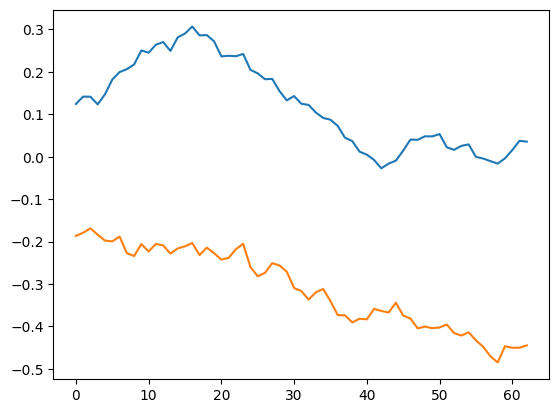

In [55]:
# results are from apple fold 1 with robust scaler.
# The [i] is the epoch that the "means" for each test observation is from
# means are found fro the MCD=50 or MCD=1 (i believe here it is 50 since std is over 0)

plt.plot(results['val_means'][1]) 
plt.plot(A_test['Close'].values)
l = []
for i in range(11):
    l.append(mse(results['val_means'][i], A_test['Close'].values))
l

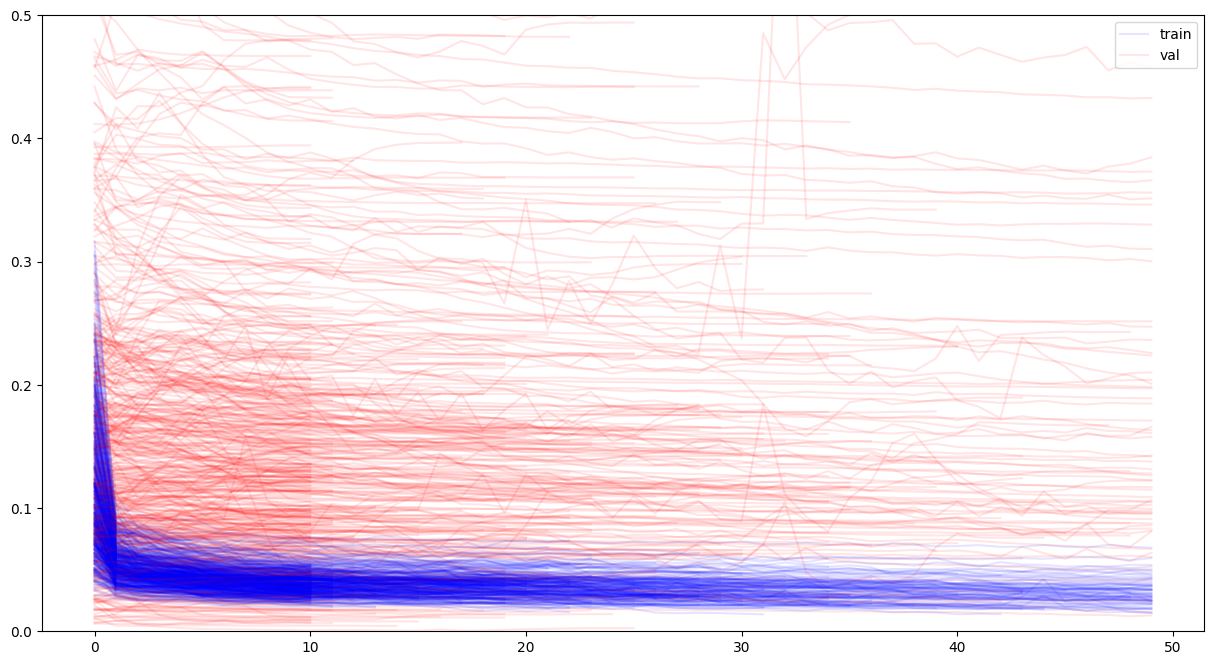

In [10]:
plt.figure(figsize=(15, 8), dpi=100)

for ticker in stock_tickers['Ticker']:
    results = GetResultsFromJSON(ticker=ticker, fold=3, exp_dir="experiments/exp_base")
    plt.plot(results['train_losses'], color="blue", alpha=0.1)
    plt.plot(results['val_losses'], color="red", alpha=0.1)

# manual coloring, blue for val, red for train in legend
plt.ylim(0, 0.5)
plt.legend(["train", "val"])


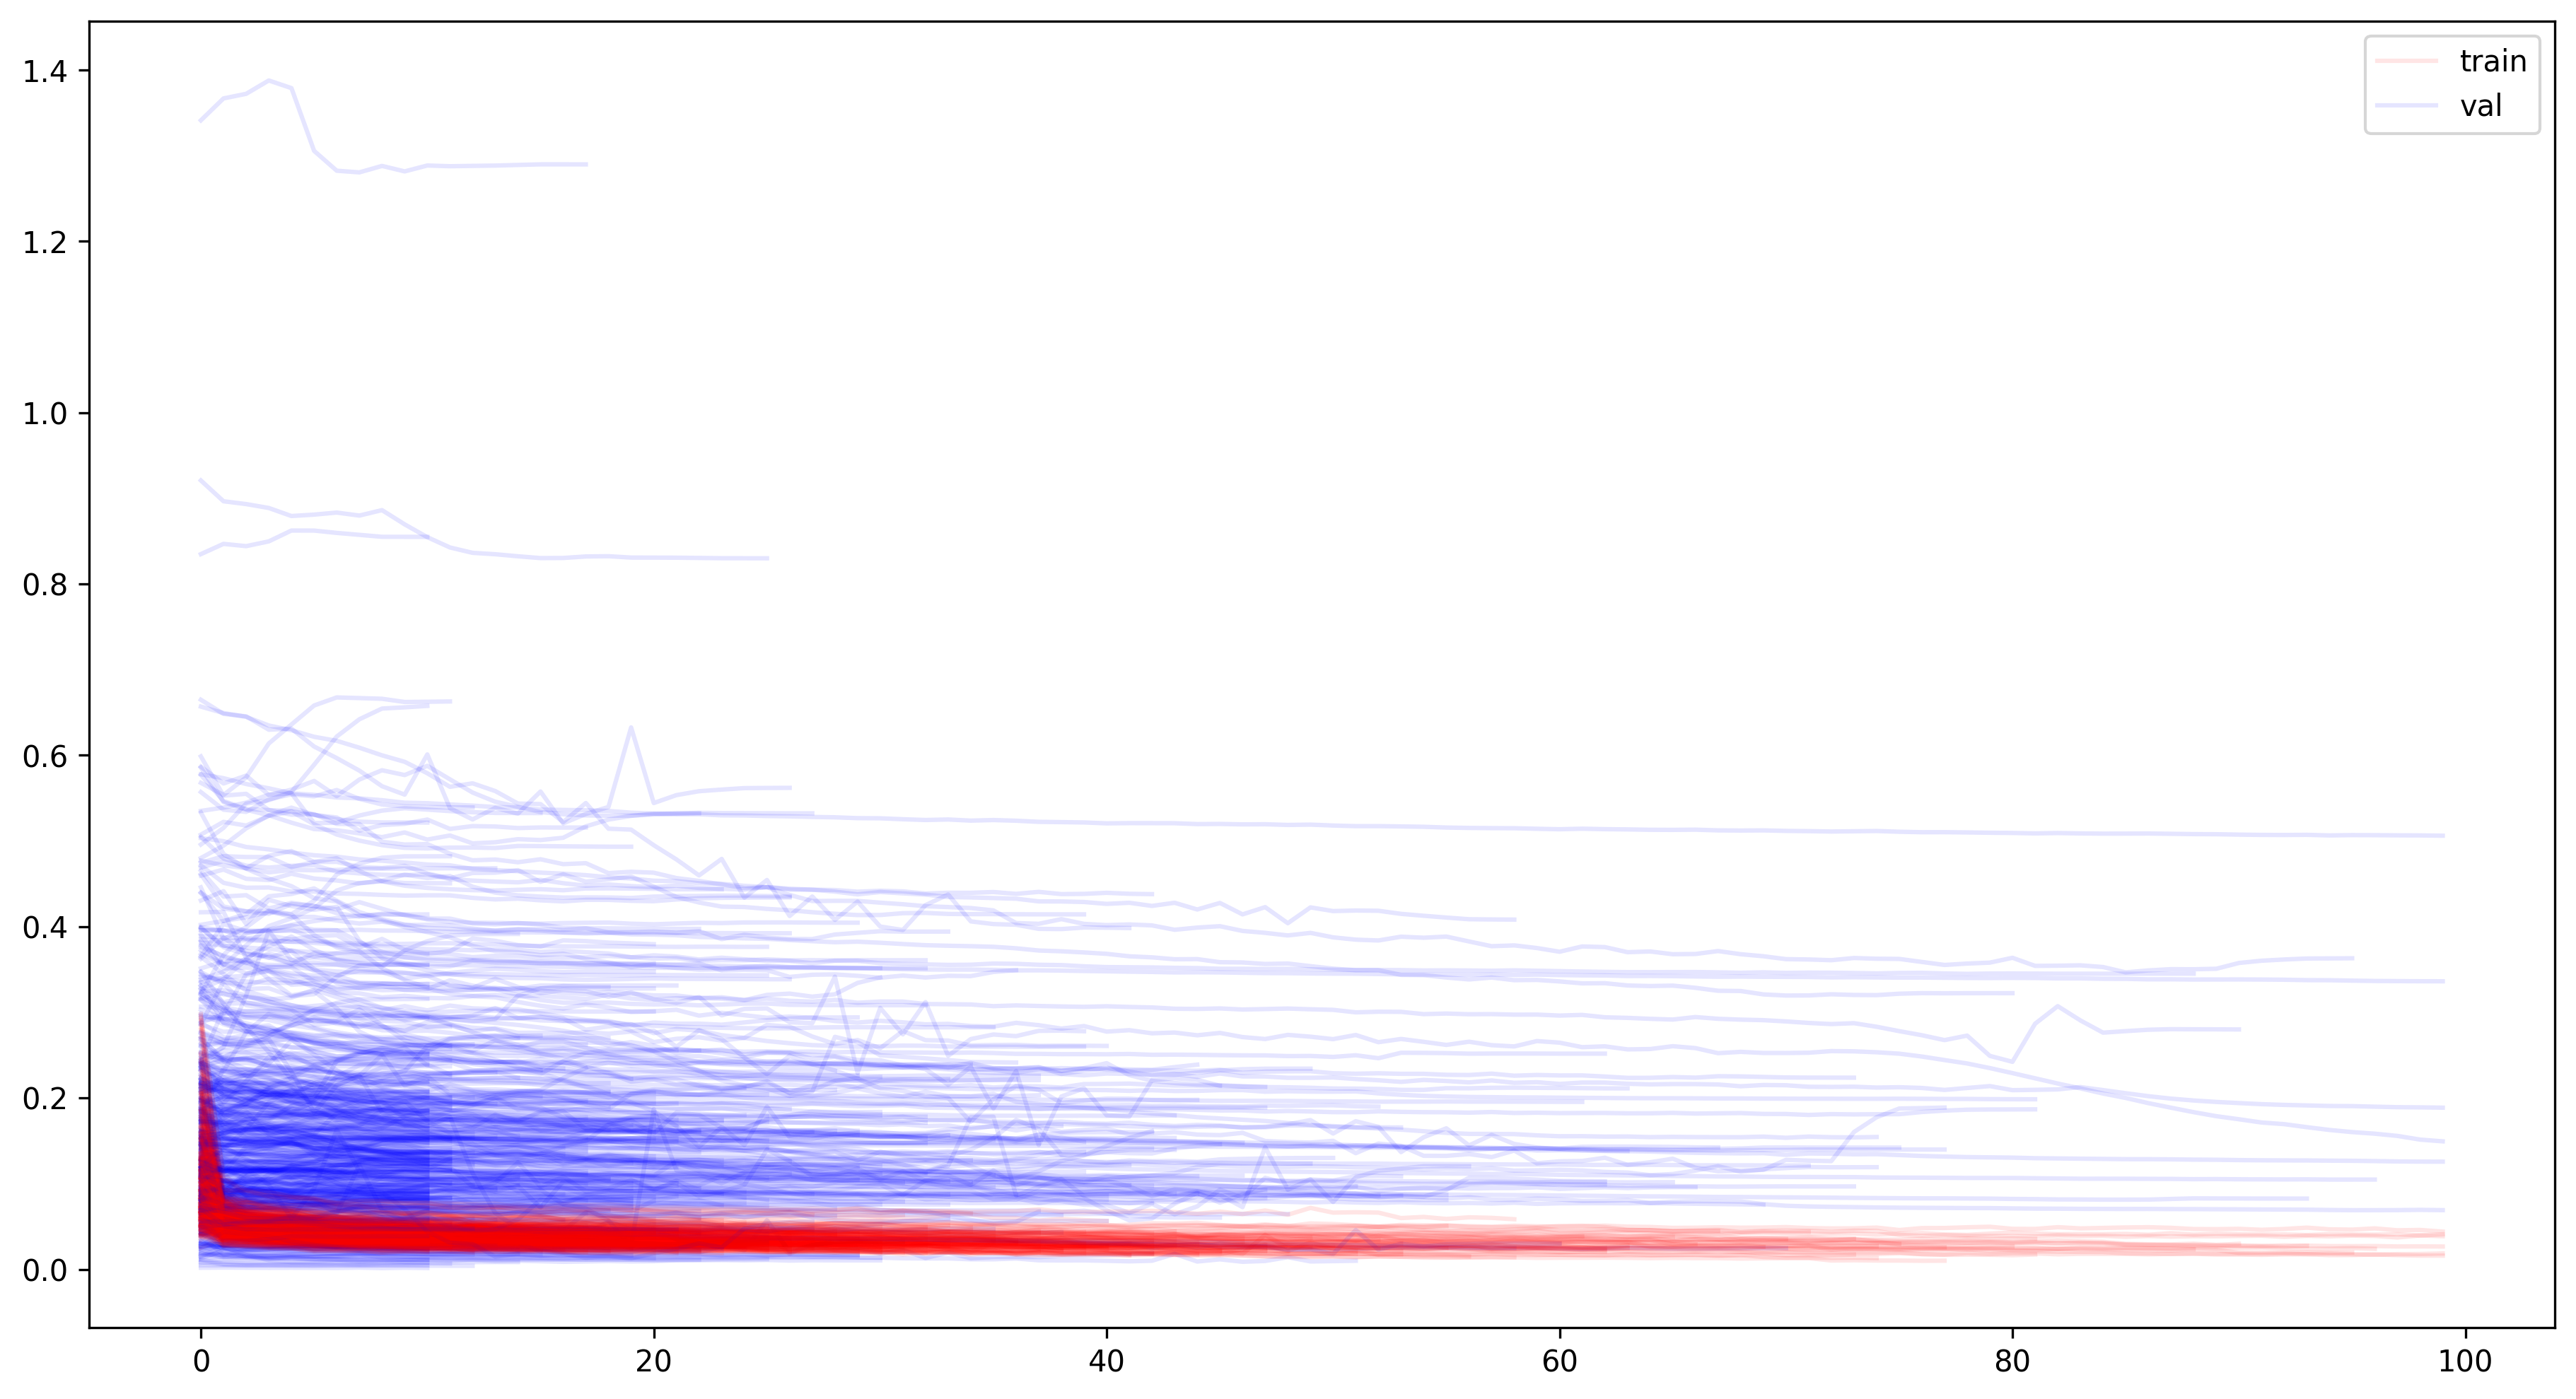

In [43]:
plt.figure(figsize=(15, 8), dpi=100)

for ticker in stock_tickers['Ticker']:
    results = GetResultsFromJSON(ticker=ticker, fold=3, exp_dir="experiments/exp")
    plt.plot(results['train_losses'], color="blue", alpha=0.1)
    plt.plot(results['val_losses'], color="red", alpha=0.1)

# manual coloring, blue for val, red for train in legend
plt.ylim(0, 0.5)
plt.legend(["train", "val"])
